# Planification de la production d'électricité

## 1. Modèle de base des centrales thermiques

### 1.1 Planification journalière du parc thermique

In [1]:
print("a")

a


In [4]:
import gurobipy as gp

Données du problème :<br>
•	Dem<sub>j</sub> : Demande défini sur 24 périodes<br>
•	Dem<sub>i</sub> : Demande défini sur 24 périodes<br>
•	nb<sub>i</sub> : le nombre maximum de centrale disponible pour chaque type i de centrale<br>
•	Pmin<sub>i</sub> : Puissance minimum autorisé pour chaque type i de centrale<br>
•	Pmax<sub>i</sub> : Puissance maximum autorisé pour chaque type i de centrale<br>
•	Cmwh<sub>i</sub> : Coût de fonctionnement pour chaque type i de centrale<br>

Variables :<br>
•	NBcentrale<sub>i,j</sub> : Nombre de centrale de type i utilisé à la période j<br>
•	Puiss<sub>i,j</sub> : Puissance délivré par les centrales de type i à la période j<br>


Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} Puiss_{i,j} * Cmwh_{i}$$

S.T : 

1.   $$NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
2.   $$\sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j}\;\;\;\;\;\;\;\;  \forall j \in \{1,..,24\} $$
3.   $$ 0 \le NBcentrale_{i,j}\le nb_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
   $$Puiss_{i,j} \in \mathbb{R} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$NBcentrale_{i,j} \in \mathbb{N} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$




In [5]:
#Demande sur 24 période
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3

#Dictionnaire pour la gestion des données par type de centrale
CENTRALE, nb, Pmin, Pmax, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 1.5],
    'B' : [10, 1250, 1750, 1.38],
    'C' : [5, 1500, 4000, 2.750],
})

model = gp.Model(name = 'Centrales thermiques')

NBcentrale = {(i,j) : model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

#Contrainte de capacité minimum pour les centrales
CSTR1 = { (i,j) : model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#Contrainte de capacité maximum pour les centrales
CSTR2 = { (i,j) : model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#Contrainte de respect de la demande
CSTR3 = { j : model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

#Contrainte sur le nombre maximum de centrale disponible
CSTR4 =  { (i,j) : model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

model.setObjective(sum(Puiss[i,j]*Cmwh[i] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

model.update()
model.optimize()

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 240 rows, 144 columns and 432 nonzeros
Model fingerprint: 0xbaa479b0
Variable types: 72 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 3e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1234360.0000
Presolve removed 234 rows and 139 columns
Presolve time: 0.06s
Presolved: 6 rows, 5 columns, 14 nonzeros
Found heuristic solution: objective 869400.00000
Variable types: 2 continuous, 3 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 869400 1.23436e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.694000000000e+05, 

In [6]:
print("Coûts d'opération :" ,round(model.objVal, 2), "€")

Coûts d'opération : 869400.0 €


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
NBA=[]; NBB=[]; NBC=[]
PA=[]; PB=[]; PC=[]; PTOT=[]


for j in range(24):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)
    NBA.append(NBcentrale["A",j].x)
    NBB.append(NBcentrale["B",j].x)
    NBC.append(NBcentrale["C",j].x)

In [9]:
ar = [PA, PB, PC, PTOT]

In [12]:
df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])


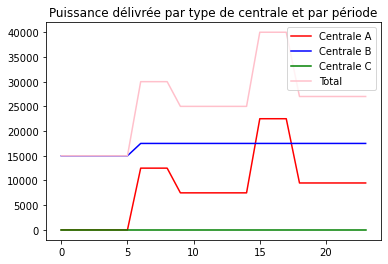

In [25]:
plt.plot(df.loc["A"],'r', label="Centrale A")
plt.plot(df.loc["B"],'b', label='Centrale B')
plt.plot(df.loc["C"],'g', label='Centrale C')
#plt.plot(Dem,'grey')
plt.plot(df.loc["TOT"],'pink', label='Total')
plt.title('Puissance délivrée par type de centrale et par période')
plt.legend()
plt.show()


In [122]:
arcentrale=[NBA, NBB, NBC]

In [124]:
dfcentrale=pd.DataFrame(data=arcentrale, index=["A", "B", "C"])
dfcentrale

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
A,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,12.0,12.0,12.0,4.0,...,4.0,12.0,12.0,12.0,5.0,5.0,5.0,5.0,5.0,5.0
B,9.0,9.0,9.0,9.0,9.0,9.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
C,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0


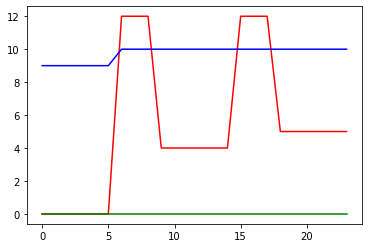

In [125]:
plt.plot(dfcentrale.loc["A"],'r')
plt.plot(dfcentrale.loc["B"],'b')
plt.plot(dfcentrale.loc["C"],'g')

plt.show()

## 2. Coûts d'opération

### 2.1 coûts de fonctionnement

Nouvelles données du problème :<br>
•	Cbase<sub>i</sub> : Coût de fonctionnement à la puissance minimale pour chaque type i de centrale<br>
•	Cmwh<sub>i</sub> : Coût supplémentaire de fonctionnement au-dessus de la  puissance minimale pour chaque type i de centrale<br>

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i}$$

S.T : 

1.   $$NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
2.   $$\sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j}\;\;\;\;\;\;\;\;  \forall j \in \{1,..,24\} $$
3.   $$ 0 \le NBcentrale_{i,j}\le nb_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
   $$Puiss_{i,j} \in \mathbb{R} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$NBcentrale_{i,j} \in \mathbb{N} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$



In [26]:
#Modification du dictionnaire pour prendre en compte les nouvelles données
CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

In [27]:
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3

In [28]:
Model = gp.Model(name = 'Centrales thermiques2')

In [29]:
NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

In [30]:
Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

In [31]:
DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

In [32]:
DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

In [33]:
CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

In [34]:
CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

In [35]:
CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

In [36]:
CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

In [37]:
#Calcul du nouveau coup de fonctionnement des centrales thermiques
Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

In [38]:
Model.setObjective(sum(Cnew[i,j] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [39]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 240 rows, 144 columns and 432 nonzeros
Model fingerprint: 0x380c2505
Variable types: 72 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1254000.0000
Presolve removed 234 rows and 139 columns
Presolve time: 0.03s
Presolved: 6 rows, 5 columns, 14 nonzeros
Found heuristic solution: objective 978900.00000
Variable types: 2 continuous, 3 integer (0 binary)

Root relaxation: objective 9.787500e+05, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      978900.000 978900.000  0.00%     -    

In [40]:
PA=[]; PB=[]; PC=[]; PTOT=[]
NBA=[]; NBB=[]; NBC=[]

for j in range(24):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)
    NBA.append(NBcentrale["A",j].x)
    NBB.append(NBcentrale["B",j].x)
    NBC.append(NBcentrale["C",j].x)

In [41]:
ar = [PA, PB, PC, PTOT]

In [42]:
df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])

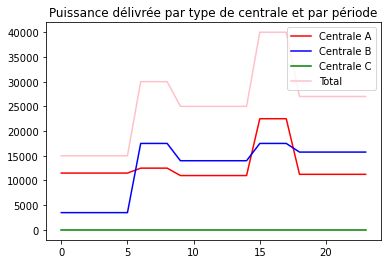

In [44]:
plt.plot(df.loc["A"],'r', label="Centrale A")
plt.plot(df.loc["B"],'b', label='Centrale B')
plt.plot(df.loc["C"],'g', label='Centrale C')
#plt.plot(Dem,'grey')
plt.plot(df.loc["TOT"],'pink', label='Total')
plt.title('Puissance délivrée par type de centrale et par période')
plt.legend()
plt.show()

### 2.2 coûts de démarage

Nouvelle donnée du problème :<br>
•   Cstart<sub>j</sub> : Coût de démarrage pour chaque type i de centrale <br>

Nouvelle variable :<br>
•   NBstart<sub>i,j</sub> : Nombre de centrale de type i qui ont été allumé à la période j


Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

1.   $$NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
2.   $$\sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j}\;\;\;\;\;\;\;\;  \forall j \in \{1,..,24\} $$
3.   $$ 0 \le NBcentrale_{i,j}\le nb_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
4.   $$ NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{2,..,24\} $$
5.   $$ NBcentrale_{i,0}\le NBstart_{i,0}  \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} $$
   $$NBstart_{i,j} \ge 0 \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$Puiss_{i,j} \in \mathbb{R} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$


In [51]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})


Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

#Intégration de la nouvelle variable au modèle
NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

#Contrainte pour le calcul du nombre de centrale de type i à allumer à la période j
CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

#Initialisation de la variable NBstart pour la 1ère période
CSTR6 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0])
         for i in CENTRALE}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

#Ajout du coût de démarage dans l'objectif
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [52]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 312 rows, 216 columns and 645 nonzeros
Model fingerprint: 0xb583e011
Variable types: 72 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1489500.0000
Presolve removed 108 rows and 30 columns
Presolve time: 0.00s
Presolved: 204 rows, 186 columns, 522 nonzeros
Variable types: 42 continuous, 144 integer (0 binary)
Found heuristic solution: objective 1412055.0000

Root relaxation: objective 1.011257e+06, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1011257.14    0   26 1412055.00 1011257.14  28.4% 

## 3. Réserve de puissance

### 3.1 Réserve

Nouvelle donnée du problème :<br>
•   Réserve : Les centrales doivent être capable de produire 15% en plus par mesure de précaution <br>

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

1.   $$NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
2.   $$\sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j}\;\;\;\;\;\;\;\;  \forall j \in \{1,..,24\} $$
3.   $$ 0 \le NBcentrale_{i,j}\le nb_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
4.   $$ NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{2,..,24\} $$
5.   $$ NBcentrale_{i,0}\le NBstart_{i,0}  \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} $$
6.   $$ \sum \limits _{i=1} ^{3} NBcentrale_{i,j} * Pmax_{i}\ge Dem_{j} * Reserve  \;\;\;\;\;\;\;\;\;\;  \forall j \in \{2,..,24\} $$
   $$NBstart_{i,j} \ge 0 \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$Puiss_{i,j} \in \mathbb{R} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$


In [57]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})


Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR6 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0])
         for i in CENTRALE}

#Calcul de la puissance délivrable potentielle
POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) 
       for j in range(len(Dem))}

#La puissance potentielle doit être supérieure à la demande plus la réserve
CSTR_31 =  { (j) : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [58]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 336 rows, 216 columns and 717 nonzeros
Model fingerprint: 0x15b20e33
Variable types: 72 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 5e+04]
Found heuristic solution: objective 1338010.0000
Presolve removed 108 rows and 30 columns
Presolve time: 0.00s
Presolved: 228 rows, 186 columns, 594 nonzeros
Found heuristic solution: objective 1291030.0000
Variable types: 42 continuous, 144 integer (0 binary)
Found heuristic solution: objective 1257225.0000

Root relaxation: objective 1.012257e+06, 67 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1

## 4 Planification cyclique

### 4.1 horizon journalier cyclique

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

1.   $$NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
2.   $$\sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j}\;\;\;\;\;\;\;\;  \forall j \in \{1,..,24\} $$
3.   $$ 0 \le NBcentrale_{i,j}\le nb_{i} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\} $$
4.   $$ NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{2,..,24\} $$
5.   $$ NBcentrale_{i,0} - NBcentrale_{i,23}\le NBstart_{i,0}  \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} $$
6.   $$ \sum \limits _{i=1} ^{3} NBcentrale_{i,j} * Pmax_{i}\ge Dem_{j} * Reserve  \;\;\;\;\;\;\;\;\;\;  \forall j \in \{1,..,24\} $$
   $$NBstart_{i,j} \ge 0 \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$Puiss_{i,j} \in \mathbb{R} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$
   $$NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} \;\;\;\;\;\;\;\;\;\;  \forall i \in \{1,2,3\} \;\;\; \forall j \in \{1,..,24\}$$

In [59]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})


Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) 
       for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

#Modification de la contrainte pour une utilisation cyclique du modèle
CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0] - NBcentrale[i,23])
         for i in CENTRALE}

CSTR_31 =  { (j) : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [60]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 336 rows, 216 columns and 720 nonzeros
Model fingerprint: 0x10bdb245
Variable types: 144 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 5e+04]
Found heuristic solution: objective 1319510.0000
Presolve removed 105 rows and 27 columns
Presolve time: 0.01s
Presolved: 231 rows, 189 columns, 603 nonzeros
Found heuristic solution: objective 1273130.0000
Variable types: 42 continuous, 147 integer (0 binary)
Found heuristic solution: objective 1239925.0000

Root relaxation: objective 9.855143e+05, 54 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 9

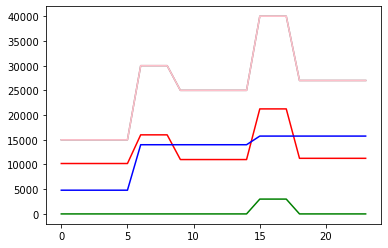

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PA=[]; PB=[]; PC=[]; PTOT=[]
NBA=[]; NBB=[]; NBC=[]



for j in range(len(Dem)):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)
    
ar = [PA, PB, PC, PTOT]

df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])

plt.plot(df.loc["A"],'r')
plt.plot(df.loc["B"],'b')
plt.plot(df.loc["C"],'g')
plt.plot(Dem,'grey')
plt.plot(df.loc["TOT"],'pink')



plt.show()

## 5 Centrales hydroélectriques

### 5.1 Centrales hydroélectriques

Nouvelles données du problème :<br>
•   HYDRO<sub>h</sub>: type h de centrale hydroélectrique <br>
•   Pfix<sub>h</sub> : Puissance fixe délivrée par chaque type de centrale h <br>
•   vab<sub>h</sub> : Vitesse d'abaissement du niveau du réservoir par chaque type de centrale h <br>
•   cdem<sub>h</sub> : Coût de démarrage de chaque type de centrale h <br>
•   cfonc<sub>h</sub> : Coût de fonctionnement de chaque type de centrale h <br>

Nouvelles variables :<br>
•   Usehydro<sub>h</sub> : Coût de fonctionnement de chaque type de centrale h <br>
•   hydrostart<sub>h</sub> : Coût de fonctionnement de chaque type de centrale h <br>


$$
\left.
    \begin{array}{ccc}        
    t \text{ appartient à la base}& \Leftrightarrow P_t^{(A)} \text{ est non nul*} &\equiv \text{ Les centrales $A$ produisent à $t$}\\        t+1 \text{ appartient à la base}& \Leftrightarrow P_t^{(B)} \text{ est non nul*} &\equiv \text{ Les centrales $B$ produisent à $t$}\\        t+2 \text{ appartient à la base}& \Leftrightarrow P_t^{(C)} \text{ est non nul*} &\equiv \text{ Les centrales $C$ produisent à $t$}\\        t+3 \text{ appartient à la base}& \Leftrightarrow S_t^{(A)} \text{ est non nul*} &\equiv \text{ Les centrales $A$ ne produisent pas au max possible à $t$}\\        t+4 \text{ appartient à la base}& \Leftrightarrow S_t^{(B)} \text{ est non nul*} &\equiv \text{ Les centrales $B$ ne produisent pas au max possible à $t$}\\        t+5 \text{ appartient à la base}& \Leftrightarrow S_t^{(C)} \text{ est non nul*} &\equiv \text{ Les centrales $C$ ne produisent pas au max possible à $t$}\\        t+6 \text{ appartient à la base}& \Leftrightarrow S_t^{(d)} \text{ est non nul*} &\equiv \text{ Les centrales produisent plus que la demande à $t$}    
    \end{array}
\right.
$$



Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} - NBcentrale_{i,23}\le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i}\ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
    & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
   & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [63]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

#Dictionnaire pour stocker les nouvelles données concernant les centrales hydroélectrique
HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [900, 0.31, 1500, 90],
    '2' : [1400, 0.47, 1200, 150],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

#Variable binaire pour l'utilisation d'un centrale de type h à la période j
Usehydro = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY)
                for h in HYDRO for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1 - Usehydro[h,j])*pfix[h] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,j]*pfix[h] for h in HYDRO),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i,j) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE}

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h) : Model.addLConstr(hydrostart[h,j],">=",Usehydro[h,j] - Usehydro[h,j-1])
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",Usehydro[h,0] - Usehydro[h,23])
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,j] * cfonc[h] + hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [64]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 312 columns and 960 nonzeros
Model fingerprint: 0x869e06d9
Variable types: 144 continuous, 168 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1361030.0000
Presolve removed 72 rows and 0 columns
Presolve time: 0.00s
Presolved: 312 rows, 312 columns, 888 nonzeros
Variable types: 72 continuous, 240 integer (96 binary)
Found heuristic solution: objective 1358380.0000

Root relaxation: objective 8.886975e+05, 90 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 888697.500    0   30 1358380.00 888697.500  34.6%

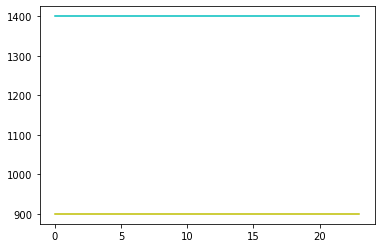

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PA=[]; PB=[]; PC=[]; PTOT=[]
H1=[]; H2=[]


for j in range(len(Dem)):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x + Usehydro["1",j].x * pfix["1"] + Usehydro["2",j].x * pfix["2"])
    H1.append(Usehydro["1",j].x * pfix["1"])
    H2.append(Usehydro["2",j].x * pfix["2"])
    
ar = [PA, PB, PC, H1, H2, PTOT]

df=pd.DataFrame(data=ar, index=["A", "B", "C", "H1", "H2","TOT"])

#plt.plot(df.loc["A"],'r')
#plt.plot(df.loc["B"],'b')
#plt.plot(df.loc["C"],'g')
plt.plot(df.loc["H1"],'y')
plt.plot(df.loc["H2"],'c')
#plt.plot(Dem,'grey')
#plt.plot(df.loc["TOT"],'pink')



plt.show()

## 5.2 Pompage

In [229]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [900, 0.31, 1500, 90],
    '2' : [1400, 0.47, 1200, 150],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1 - Usehydro[h,j])*pfix[h] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,j]*pfix[h] for h in HYDRO),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",Usehydro[h,j] - Usehydro[h,j-1])
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",Usehydro[h,0] - Usehydro[h,23])
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h] * Usehydro[h,j] for h in HYDRO for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}


Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,j] * cfonc[h] + hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [230]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 385 rows, 336 columns and 1056 nonzeros
Model fingerprint: 0x2f9d639b
Variable types: 168 continuous, 168 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Presolve removed 72 rows and 0 columns
Presolve time: 0.00s
Presolved: 313 rows, 336 columns, 984 nonzeros
Variable types: 96 continuous, 240 integer (96 binary)
Found heuristic solution: objective 1146770.0000
Found heuristic solution: objective 1072390.0000

Root relaxation: objective 9.850143e+05, 154 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   26 1072390.00 985014.286  8.15

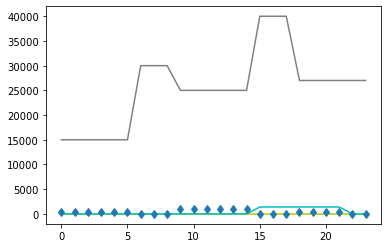

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PA=[]; PB=[]; PC=[]; PTOT=[]
H1=[]; H2=[]
P=[]

for j in range(len(Dem)):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x + Usehydro["1",j].x * pfix["1"] + Usehydro["2",j].x * pfix["2"])
    H1.append(Usehydro["1",j].x * pfix["1"])
    H2.append(Usehydro["2",j].x * pfix["2"])
    P.append(Startpump[j].x * 3000)
    
ar = [PA, PB, PC, H1, H2, P, PTOT]

df=pd.DataFrame(data=ar, index=["A", "B", "C", "H1", "H2", "P", "TOT"])

#plt.plot(df.loc["A"],'r')
#plt.plot(df.loc["B"],'b')
#plt.plot(df.loc["C"],'g')
plt.plot(df.loc["H1"],'y')
plt.plot(df.loc["H2"],'c')
plt.plot(df.loc["P"],'d')
plt.plot(Dem,'grey')
#plt.plot(df.loc["TOT"],'pink')



plt.show()

In [220]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
A,10200.0,10200.0,10200.0,10200.0,10200.0,10200.0,14250.0,14250.0,14250.0,10200.0,...,10200.0,19600.0,19600.0,19600.0,10200.0,10200.0,10200.0,10200.0,11320.0,11250.0
B,5250.0,5250.0,5250.0,5250.0,5250.0,5250.0,15750.0,15750.0,15750.0,15750.0,...,15750.0,17500.0,17500.0,17500.0,15750.0,15750.0,15750.0,15750.0,15750.0,15750.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1500.0,1500.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0
H1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,-0.0,-0.0
P,450.0,450.0,450.0,450.0,450.0,450.0,0.0,0.0,0.0,950.0,...,950.0,0.0,0.0,0.0,350.0,350.0,350.0,350.0,70.0,0.0
TOT,15450.0,15450.0,15450.0,15450.0,15450.0,15450.0,30000.0,30000.0,30000.0,25950.0,...,25950.0,40000.0,40000.0,40000.0,27350.0,27350.0,27350.0,27350.0,27070.0,27000.0


### 5.3 Paliers de fonctionnement

In [288]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix[h])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}                                   
                                  
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [289]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 433 rows, 480 columns and 1968 nonzeros
Model fingerprint: 0x2178b95c
Variable types: 168 continuous, 312 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 4e+04]
Presolve removed 72 rows and 0 columns
Presolve time: 0.00s
Presolved: 361 rows, 480 columns, 1896 nonzeros
Variable types: 96 continuous, 384 integer (240 binary)
Found heuristic solution: objective 1146770.0000
Found heuristic solution: objective 1086990.0000

Root relaxation: objective 9.850143e+05, 186 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   26 1086990.00 985014.286  9.

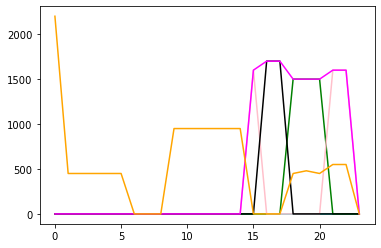

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


H11=[]; H12=[]; H13=[]; H14=[]
H21=[]; H22=[]; H23=[]; H24=[]
P=[]; HDS=[]

for j in range(24):
    H11.append(Usehydro["1",0, j].x * pfix["1"][0])
    H12.append(Usehydro["1",1, j].x * pfix["1"][1])
    H13.append(Usehydro["1",2, j].x * pfix["1"][2])
    H14.append(Usehydro["1",3, j].x * pfix["1"][3])
    H21.append(Usehydro["2",0, j].x * pfix["2"][0])
    H22.append(Usehydro["2",1, j].x * pfix["2"][1])
    H23.append(Usehydro["2",2, j].x * pfix["2"][2])
    H24.append(Usehydro["2",3, j].x * pfix["2"][3])
    P.append(Startpump[j].x * 3000)
    HDS.append(sum(pfix["2"][p]*Usehydro["2",p,j].x for p in vab["2"]))
    

ar = [H11, H12, H13, H14, H21, H22, H23, H24, HDS, P]

df=pd.DataFrame(data=ar, index=["H11", "H12", "H13", "H14", "H21", "H22", "H23", "H24", "HDS", "P"])


#plt.plot(df.loc["H11"],'r')
#plt.plot(df.loc["H12"],'b')
#plt.plot(df.loc["H13"],'g')
#plt.plot(df.loc["H14"],'y')
plt.plot(df.loc["H21"],'c')
plt.plot(df.loc["H22"],'g')
plt.plot(df.loc["H23"],'pink')
plt.plot(df.loc["H24"],'black')
plt.plot(df.loc["HDS"],'magenta')
plt.plot(df.loc["P"],'orange')
#plt.plot(df.loc["TOT"],'pink')


In [269]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
H11,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H12,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H13,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H14,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H21,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H22,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,1500.0,1500.0,1500.0,-0.0,-0.0,-0.0
H23,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,1600.0,0.0,-0.0,0.0,0.0,-0.0,1600.0,1600.0,-0.0
H24,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,1700.0,1700.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
HDS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1600.0,1700.0,1700.0,1500.0,1500.0,1500.0,1600.0,1600.0,0.0


### 5.4 Exclusion pompage et génération hydro

In [296]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix['1'])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['2',p,j] for p in vab['2']))
          for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['1',p,j] for p in vab['1']))
          for j in range(len(Dem))}
                                  
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [297]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 481 rows, 480 columns and 2208 nonzeros
Model fingerprint: 0x43402823
Variable types: 168 continuous, 312 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 4e+04]
Presolve removed 120 rows and 0 columns
Presolve time: 0.00s
Presolved: 361 rows, 480 columns, 1944 nonzeros
Variable types: 96 continuous, 384 integer (240 binary)
Found heuristic solution: objective 1146770.0000
Found heuristic solution: objective 1086990.0000

Root relaxation: objective 9.850143e+05, 173 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   26 1086990.00 985014.286  9

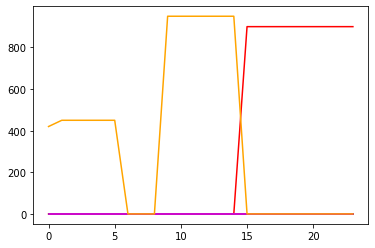

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


H11=[]; H12=[]; H13=[]; H14=[]
H21=[]; H22=[]; H23=[]; H24=[]
P=[]; HDS=[]

for j in range(24):
    H11.append(Usehydro["1",0, j].x * pfix["1"][0])
    H12.append(Usehydro["1",1, j].x * pfix["1"][1])
    H13.append(Usehydro["1",2, j].x * pfix["1"][2])
    H14.append(Usehydro["1",3, j].x * pfix["1"][3])
    H21.append(Usehydro["2",0, j].x * pfix["2"][0])
    H22.append(Usehydro["2",1, j].x * pfix["2"][1])
    H23.append(Usehydro["2",2, j].x * pfix["2"][2])
    H24.append(Usehydro["2",3, j].x * pfix["2"][3])
    P.append(Startpump[j].x * 3000)
    HDS.append(sum(pfix["2"][p]*Usehydro["2",p,j].x for p in vab["2"]))
    

ar = [H11, H12, H13, H14, H21, H22, H23, H24, HDS, P]

df=pd.DataFrame(data=ar, index=["H11", "H12", "H13", "H14", "H21", "H22", "H23", "H24", "HDS", "P"])


plt.plot(df.loc["H11"],'r')
plt.plot(df.loc["H12"],'b')
plt.plot(df.loc["H13"],'g')
plt.plot(df.loc["H14"],'y')
plt.plot(df.loc["H21"],'c')
plt.plot(df.loc["H22"],'g')
plt.plot(df.loc["H23"],'pink')
plt.plot(df.loc["H24"],'black')
plt.plot(df.loc["HDS"],'magenta')
plt.plot(df.loc["P"],'orange')
#plt.plot(df.loc["TOT"],'pink')


In [300]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
H11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
H12,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H13,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H14,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H21,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H22,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
H23,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
H24,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
HDS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P,420.0,450.0,450.0,450.0,450.0,450.0,0.0,0.0,0.0,950.0,...,950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [303]:
somme=0
for i in range(24):
    somme=somme+P[i]

In [304]:
somme

8370.000000000002